## Import Packages

In [1]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import copy
import random
import matplotlib.pyplot as plt

from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask
from collections import defaultdict
from tqdm import tqdm

%matplotlib inline

## Read Annotations files & DataFrame

In [2]:
dataset_path  = './segmentation/input/data/'
df = pd.read_csv('./segmentation/baseline_code/class_dict.csv')

category_names = list(df.name)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

In [3]:
## 증강시킬 json 파일을 train_path에 넣어주세요
json_path = dataset_path + '/train_all.json'

coco = COCO(json_path)

with open(json_path, 'r') as f:
    json_data = json.load(f)

loading annotations into memory...
Done (t=4.45s)
creating index...
index created!


## Define Options

In [48]:
# 증강시키고자 하는 mask_class 선언
# ex) battery를 증강하려면 9 입력

mask_class = 9

In [49]:
# 원하는 mask_class가 들어있는 images의 인덱스들
foreground_images = []

for idx in tqdm(range(len(json_data['images']))):
# for idx in range(3):
    image_id = coco.getImgIds(imgIds=idx)
    image_infos = coco.loadImgs(image_id)[0]
    
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    
    category_type = []
    for i in range(len(anns)):
        category_id = anns[i]['category_id']
        if category_id == mask_class:
            foreground_images.append(idx)
            break

100%|██████████| 3272/3272 [00:00<00:00, 66236.29it/s]


In [50]:
# json data 파일의 마지막 images id가 3271이므로
last_images_id = json_data['images'][-1]['id']

# mask_class가 없는 이미지에 증강시킬 목적으로 
# mask_class가 없는 이미지들의 인덱스 background_images 선언
background_images = range(last_images_id)
background_images = [x for x in background_images if x not in foreground_images]

In [51]:
# 증강시킬 개수 k
# 일단 여기서는 k == 1이기 때문에 

k = 1
fg_image_idx = random.sample(foreground_images, k)
bg_image_idx = random.sample(background_images, k)

[3165, 168, 758, 2118, 153] [2912, 799, 61, 2740, 1899]


## Augmentation

### Find Background Space from Original Image

In [52]:
## 원본으로 쓰일 이미지
## 여기서는 원본 이미지에서 배경에 해당하는 공간을 찾을 것임

## idx에 해당하는 이미지 정보 추출
idx = bg_image_idx

image_id = coco.getImgIds(imgIds=idx)
image_infos = coco.loadImgs(image_id)[0]

ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
anns = coco.loadAnns(ann_ids)

cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

masks = np.zeros((image_infos["height"], image_infos["width"]))

anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
for i in range(len(anns)):
    className = get_classname(anns[i]['category_id'], cats)
    pixel_value = category_names.index(className)
    masks[coco.annToMask(anns[i]) == 1] = pixel_value

masks = masks.astype(np.int8)

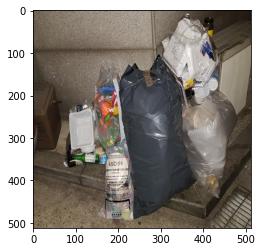

In [53]:
# 해당 이미지 시각화
images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

# temp_images에다가 합성할 예정
temp_infos = copy.deepcopy(image_infos)
temp_images = copy.deepcopy(images)
plt.imshow(images)

In [54]:
# background에서 빈 공간을 찾기 위해
# background_mask 선언
background_mask = (masks == 0)


# 공간 찾는 로직
edge = 0
graph = [[x for x in sub] for sub in background_mask]

for x in range(1, len(graph)):
    for y in range(1, len(graph)):
        if graph[x][y] == 0:
            continue
        else:
            _min = min([graph[x][y-1], graph[x-1][y], graph[x-1][y-1]])
            graph[x][y] = _min + 1
            if edge < graph[x][y]:
                edge = graph[x][y]
                  
flag = False

for x in range(1, len(graph)):
    if flag: 
        break
    for y in range(1, len(graph)):
        if graph[x][y] == edge:
            empty_ymax, empty_xmax = x+1, y+1
            flag = True
            break
            
# 찾은 빈공간 확인
# plt.imshow(images[empty_ymax-edge:empty_ymax, empty_xmax-edge:empty_xmax])

### Extract Image Mask

In [55]:
## 추출하려는 이미지
## 여기서는 원하는 mask_class에 따라 물체를 추출할 것임

## idx에 해당하는 이미지 정보 추출
idx = fg_image_idx

image_id = coco.getImgIds(imgIds=idx)
image_infos = coco.loadImgs(image_id)[0]

ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
anns = coco.loadAnns(ann_ids)

cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

masks = np.zeros((image_infos["height"], image_infos["width"]))

anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
for i in range(len(anns)):
    className = get_classname(anns[i]['category_id'], cats)
    pixel_value = category_names.index(className)
    masks[coco.annToMask(anns[i]) == 1] = pixel_value

masks = masks.astype(np.int8)

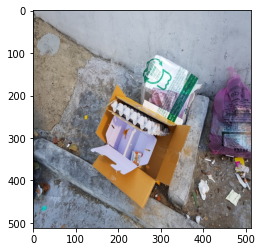

In [56]:
# 해당 이미지 시각화

images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
plt.imshow(images)

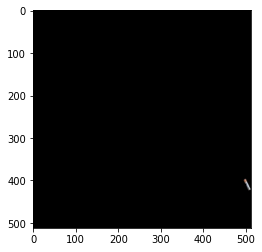

In [57]:
masks = (masks == mask_class).astype(np.int8)

# masking된 모든 물체 src
# src를 뺀 background 선언

src = cv2.bitwise_and(images, images, mask=masks)
background = cv2.bitwise_not(images, images, mask=masks)

plt.imshow(src)

In [58]:
## 해당 물체의 bbox 찾는 로직
## class당 annotation이 여러개일 수 있기 때문에 for문을 통해 bbox 탐지

ymin, ymax = 0, 0

for y in range(len(src)):
    if (masks[y].sum() != 0) and ymin == 0:
        ymin = y
    elif masks[y].sum() != 0:
        ymax = y        

xmin, xmax = 0, 0

for x in range(len(src[0])):
    if (masks[:, x].sum() != 0) and xmin == 0:
        xmin = x
    elif masks[:, x].sum() != 0:
        xmax = x

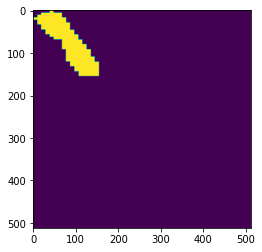

In [59]:
## segmenatation값 처리

segmentation_roi = masks[ymin:ymax, xmin:xmax]
resized_segmentation_roi = cv2.resize(segmentation_roi.astype(np.uint8), dsize=(edge, edge), interpolation=cv2.INTER_AREA)

segmentation_mask = np.zeros((512, 512))
segmentation_mask[empty_ymax-edge:empty_ymax, empty_xmax-edge:empty_xmax] = resized_segmentation_roi
plt.imshow(segmentation_mask)

In [60]:
# mask 물체 추출
extract_mask = src[ymin:ymax, xmin:xmax]
# plt.imshow(extract_mask)

In [61]:
# 빈공간 size에 맞게 resize
if edge * edge > (ymax-ymin) * (xmax-xmin):
    resized_src = cv2.resize(extract_mask, dsize=(edge, edge), interpolation=cv2.INTER_AREA)
else:
    resized_src = cv2.resize(extract_mask, dsize=(edge, edge), interpolation=cv2.INTER_CUBIC)
# plt.imshow(resized_src)

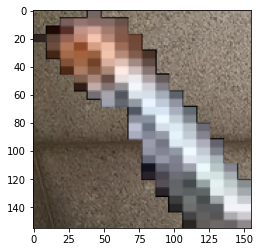

In [62]:
# 원본 이미지에서 관심영역(roi) 설정
# roi는 원본 이미지에서 찾은 빈 공간
roi = temp_images[empty_ymax-edge:empty_ymax, empty_xmax-edge:empty_xmax]

# 이미지 합성을 위해 bg_mask, fg_mask 생성
resized_src_gray = cv2.cvtColor(resized_src, cv2.COLOR_BGR2GRAY)

bg_mask = (resized_src_gray == 0).astype(np.int8)
fg_mask = (resized_src_gray != 0).astype(np.int8)

# roi에서 뜯어 붙일 이미지 공간을 제외한 배경 추출
# resized_src에서 뜯어 붙일 이미지 추출
bg = cv2.bitwise_and(roi, roi, mask=bg_mask)
fg = cv2.bitwise_and(resized_src, resized_src, mask=fg_mask)

# 이미지 합성
merged_image = cv2.bitwise_or(bg, fg)

# 합성 사진 시각화
plt.imshow(merged_image)

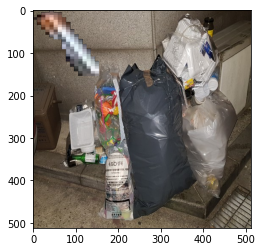

In [63]:
# 원본 이미지에 합성한 이미지 붙이기
temp_images[empty_ymax-edge:empty_ymax, empty_xmax-edge:empty_xmax] = merged_image

# 최종 결과물 시각화
plt.imshow(temp_images)

## Save Augmented Image

In [65]:
## 증강된 이미지 저장

saved_dir = '/opt/ml/segmentation/input/data/augmented/'
file_name_dir = 'augmented/'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

temp_images = cv2.cvtColor(temp_images, cv2.COLOR_BGR2RGB)
cv2.imwrite(saved_dir + temp_infos['file_name'].split('/')[-1], temp_images)

True

## Update Json

In [66]:
# 수정해야할 image_id
revised_id = temp_infos['id']

# json으로 읽어들일 image 수정
json_data['images'][revised_id]['file_name'] = file_name_dir + temp_infos['file_name'].split('/')[-1]

In [67]:
fortran_ground_truth_binary_mask = np.asfortranarray(segmentation_mask).astype(np.uint8)
encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
ground_truth_area = mask.area(encoded_ground_truth)
ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
contours, hierarchy = cv2.findContours(segmentation_mask.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

annotation = {
        "segmentation": [],
        "area": ground_truth_area.tolist(),
        "iscrowd": 0,
        "image_id": temp_infos['id'],
        "bbox": ground_truth_bounding_box.tolist(),
        "category_id": mask_class,
        "id": json_data['annotations'][-1]['id'] + 1
    }


for contour in contours:
    contour = np.flip(contour, axis=1)
    segmentation = contour.ravel().tolist()
    annotation['segmentation'].append(segmentation)

In [68]:
json_data['annotations'].append(annotation)

In [69]:
json_data['annotations'][-1]['id']

26404

## Save New Json File

In [ ]:
# 증강이 끝나면 json file 저장

with open(dataset_path + 'mix_json.json', 'w') as outfile:
    json.dump(json_data, outfile)